In [2]:
import torch
import numpy as np
import ex
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import sleep 

from torchvision import transforms 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim 

In [3]:
torch.cuda.is_available()

True

In [4]:
file_path = "cifar-10-batches-py"
train, test = ex.iter_files(file_path)

In [5]:
def images_labels(dataset: str):
    if dataset == "train":
        labels = torch.Tensor()
        images = torch.Tensor()
        for batch in train:
            lab = batch[0]
            img = ex.batch2images(batch[1])
            labels = torch.cat((labels, lab))
            images = torch.cat((images, img))
    elif dataset == "test":
        images = ex.batch2images(test[0][1])
        labels = test[0][0]
    return images.to(torch.float), labels.to(torch.long)
#     return images.to(torch.float)/255, labels.to(torch.long) 

train_images, train_labels = images_labels("train")
test_images, test_labels = images_labels("test")

In [6]:
# train_images[0]

In [14]:
class Dataset:
    def __init__(self, images: torch.Tensor, labels: torch.Tensor, mode: str):
        self.mode = mode
        self.images = images
        self.labels = labels
        self.train_transform = transforms.Compose([transforms.ToPILImage(),
                                                   transforms.RandomHorizontalFlip(0.3), # FLips the image w.r.t horizontal axis
                                                   transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                                   transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                                   transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                                   transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                                   transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                                        std=[0.5, 0.5, 0.5])]) #Normalize all the images
                                                  
 
 
        self.test_transform = transforms.Compose([transforms.ToPILImage(),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                 ])
    def __len__(self):
        a = self.labels.shape[0]
        return a
    
    def __getitem__(self, index):
#         image = self.images[index]
        image = self.images[index].transpose(0,2)
        label = self.labels[index]
        if self.mode == "train":
            image = self.train_transform(image)
        elif self.mode == "test":
            image = self.test_transform(image)
        return image, label

In [15]:
train_dataset = Dataset(train_images, train_labels, "train")
test_dataset = Dataset(test_images, test_labels, "test")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle = True, pin_memory=True)

Below are some of the examples of images after the transforms. Some transforms like `RandomHorizontalFlip` and `RandomVerticalFlip` are applied randomly with a probability of 0.5 (set by the user).

In [16]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)

        x = torch.randn(32,32,3).view(-1,3,32,32)
        
        self._to_linear = None 
        self.convs(x)
        
        self.fc = nn.Linear(self._to_linear, 10)
        
    def convs(self,x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x , (2,2))
        
        #Block 2
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x , (2,2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.fc(x)
        return x

In [17]:
def train(model, optimizer, dataloader):
    for x,y in dataloader:
        x, y = x.to('cuda:0'), y.to('cuda:0')
        optimizer.zero_grad()
        prediction = model.forward(x)
        loss = nn.CrossEntropyLoss()
        output_loss = loss(prediction, y)
        output_loss.backward()
        optimizer.step()
    return output_loss

def accuracy(model, dataloader):
    hits = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to('cuda:0'), y.to('cuda:0')
            prediction = model.forward(x)
            prediction = torch.argmax(prediction, dim=1)
            hits += (prediction == y).count_nonzero()
    acc = hits / len(dataloader.dataset)
    return acc

In [18]:
def training(model_factory, dataloader, optimizer_factory, epochs):
    losses = torch.zeros(epochs)
    accuracies = torch.zeros(epochs)
    model = model_factory.to('cuda:0')
    optimizer = optimizer_factory
    
    for epoch in tqdm(range(epochs)):
        losses[epoch] = train(model, optimizer, dataloader)
        accuracies[epoch] = accuracy(model, test_loader)
        sleep(0.1)
        print(f"Loss of Epoch {epoch} is {losses[epoch]}")
        print(f"Accuracy of Epoch {epoch} is {accuracies[epoch]}")
    return losses, accuracies

In [19]:
model = Network()
optimizer = optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.95))
losses, accuracies = training(model, train_loader, optimizer, 25) 

  4%|▍         | 1/25 [00:29<11:44, 29.36s/it]

Loss of Epoch 0 is 1.689257025718689
Accuracy of Epoch 0 is 0.4106999933719635


  8%|▊         | 2/25 [00:58<11:14, 29.32s/it]

Loss of Epoch 1 is 1.5817596912384033
Accuracy of Epoch 1 is 0.4861999750137329


 12%|█▏        | 3/25 [01:27<10:44, 29.27s/it]

Loss of Epoch 2 is 1.3382668495178223
Accuracy of Epoch 2 is 0.5116999745368958


 16%|█▌        | 4/25 [01:56<10:14, 29.24s/it]

Loss of Epoch 3 is 1.3128012418746948
Accuracy of Epoch 3 is 0.5534999966621399


 20%|██        | 5/25 [02:26<09:44, 29.22s/it]

Loss of Epoch 4 is 1.1723840236663818
Accuracy of Epoch 4 is 0.5726999640464783


 24%|██▍       | 6/25 [02:56<09:23, 29.68s/it]

Loss of Epoch 5 is 1.2884705066680908
Accuracy of Epoch 5 is 0.5873000025749207


 28%|██▊       | 7/25 [03:26<08:52, 29.58s/it]

Loss of Epoch 6 is 1.2652548551559448
Accuracy of Epoch 6 is 0.5988999605178833


 32%|███▏      | 8/25 [03:55<08:20, 29.45s/it]

Loss of Epoch 7 is 1.3614375591278076
Accuracy of Epoch 7 is 0.6148999929428101


 36%|███▌      | 9/25 [04:24<07:51, 29.45s/it]

Loss of Epoch 8 is 1.2599239349365234
Accuracy of Epoch 8 is 0.6207000017166138


 40%|████      | 10/25 [04:54<07:21, 29.46s/it]

Loss of Epoch 9 is 1.0122946500778198
Accuracy of Epoch 9 is 0.630899965763092


 44%|████▍     | 11/25 [05:24<06:54, 29.63s/it]

Loss of Epoch 10 is 1.3933899402618408
Accuracy of Epoch 10 is 0.6504999995231628


 48%|████▊     | 12/25 [05:54<06:29, 29.93s/it]

Loss of Epoch 11 is 1.219300627708435
Accuracy of Epoch 11 is 0.6603999733924866


 52%|█████▏    | 13/25 [06:25<05:59, 29.99s/it]

Loss of Epoch 12 is 1.1970078945159912
Accuracy of Epoch 12 is 0.6545999646186829


 56%|█████▌    | 14/25 [06:55<05:29, 29.99s/it]

Loss of Epoch 13 is 1.3046292066574097
Accuracy of Epoch 13 is 0.659500002861023


 60%|██████    | 15/25 [07:24<04:58, 29.89s/it]

Loss of Epoch 14 is 1.003197193145752
Accuracy of Epoch 14 is 0.6662999987602234


 64%|██████▍   | 16/25 [07:54<04:29, 29.90s/it]

Loss of Epoch 15 is 0.9773710370063782
Accuracy of Epoch 15 is 0.6768999695777893


 68%|██████▊   | 17/25 [08:24<04:00, 30.02s/it]

Loss of Epoch 16 is 0.8931859731674194
Accuracy of Epoch 16 is 0.6736999750137329


 72%|███████▏  | 18/25 [08:55<03:31, 30.15s/it]

Loss of Epoch 17 is 1.0301859378814697
Accuracy of Epoch 17 is 0.6794999837875366


 76%|███████▌  | 19/25 [09:25<03:01, 30.20s/it]

Loss of Epoch 18 is 0.9605079889297485
Accuracy of Epoch 18 is 0.6821999549865723


 80%|████████  | 20/25 [09:56<02:31, 30.27s/it]

Loss of Epoch 19 is 1.0255753993988037
Accuracy of Epoch 19 is 0.6868999600410461


 84%|████████▍ | 21/25 [10:26<02:01, 30.45s/it]

Loss of Epoch 20 is 0.7889000177383423
Accuracy of Epoch 20 is 0.6872000098228455


 88%|████████▊ | 22/25 [10:57<01:31, 30.49s/it]

Loss of Epoch 21 is 0.7054110765457153
Accuracy of Epoch 21 is 0.6832000017166138


 92%|█████████▏| 23/25 [11:27<01:00, 30.39s/it]

Loss of Epoch 22 is 0.9991517066955566
Accuracy of Epoch 22 is 0.699999988079071


 96%|█████████▌| 24/25 [11:57<00:30, 30.28s/it]

Loss of Epoch 23 is 0.9182754755020142
Accuracy of Epoch 23 is 0.7023999691009521


100%|██████████| 25/25 [12:27<00:00, 29.91s/it]

Loss of Epoch 24 is 1.0454332828521729
Accuracy of Epoch 24 is 0.6972000002861023


In [289]:
def plotting_losses(cnn):
    plt.plot(cnn.detach(), 'r', label="CNN")
#     plt.plot(fc, 'k', label="baseline")
    plt.legend()
    plt.show()
    
def acc_plot(cnn):
    plt.plot(cnn, 'r', label="CNN")
#     plt.plot(fc, 'k', label="Dense")
    plt.legend()
    plt.show()

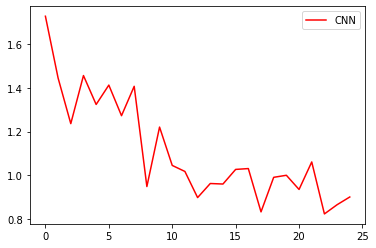

In [290]:
plotting_losses(losses)

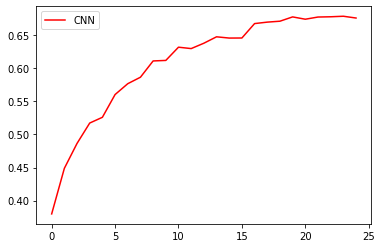

In [291]:
acc_plot(accuracies)